In [1]:
from ema_workbench import Scenario, Policy, MultiprocessingEvaluator, ema_logging, load_results
from ema_workbench.analysis import prim
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.em_framework.evaluators import BaseEvaluator

from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ema_workbench.analysis import parcoords
import seaborn as sns

In [25]:
ACTORNAME = "Gorssel"
dike_model, planning_steps = get_model_for_problem_formulation(ACTORNAME)

# Scenario selection

In [3]:
ACTOR = "genscen_Gorssel_50000_09-06-2021-01-38-16.tar.gz"
experiments, outcomes = load_results("data/generated/" + ACTOR)
outcomes_df = pd.DataFrame(outcomes)

In [4]:
outcomes_df.columns.values.tolist()

['Difference in Expected Annual Damage Gorssel-Deventer',
 'Difference in Expected Number of Deaths Gorssel-Deventer',
 'Gorssel Expected Annual Damage',
 'Gorssel Expected Number of Deaths',
 'Total Costs of Policies']

In [5]:
DAMAGE = outcomes_df.columns[2]
DEATHS = outcomes_df.columns[3]
COSTS = outcomes_df.columns[4]

In [6]:
results = pd.concat([experiments, outcomes_df], axis=1)

In [7]:
worst_damage_df = results.loc[results[DAMAGE] > np.percentile(a=outcomes[DAMAGE], q=90)]
worst_deaths_df = results.loc[results[DEATHS] > np.percentile(a=outcomes[DEATHS], q=90)]
worst_cost_df = results.loc[results[COSTS] > np.percentile(a=outcomes[COSTS], q=90)]
worst_ix =set(worst_damage_df["scenario"].tolist()) & set(worst_deaths_df["scenario"].tolist()) & set(worst_cost_df["scenario"].tolist())

In [8]:
worst_case = results.iloc[list(worst_ix)].sample(n=1, random_state=1)

In [9]:
best_damage_df = results.loc[results[DAMAGE] <= np.percentile(a=outcomes[DAMAGE], q=10)]
best_deaths_df = results.loc[results[DEATHS] <= np.percentile(a=outcomes[DEATHS], q=10)]
best_cost_df = results.loc[results[COSTS] <= np.percentile(a=outcomes[COSTS], q=10)]
best_ix = set(best_damage_df["scenario"].tolist()) & set(best_deaths_df["scenario"].tolist()) & set(best_cost_df["scenario"].tolist())

In [10]:
best_case = results.iloc[list(best_ix)].sample(n=1, random_state=1)

In [11]:
middle_damage_df = results.loc[(results[DAMAGE] > np.percentile(a=outcomes[DAMAGE], q=45)) & (results[DAMAGE] <= np.percentile(a=outcomes[DAMAGE], q=55))]
middle_deaths_df = results.loc[(results[DEATHS] > np.percentile(a=outcomes[DEATHS], q=45)) & (results[DEATHS] <= np.percentile(a=outcomes[DEATHS], q=55))]
middle_cost_df = results.loc[(results[COSTS] > np.percentile(a=outcomes[COSTS], q=45)) & (results[COSTS] <= np.percentile(a=outcomes[COSTS], q=55))]
middle_ix =set(middle_damage_df["scenario"].tolist()) & set(middle_deaths_df["scenario"].tolist()) & set(middle_cost_df["scenario"].tolist())

In [12]:
middle_case = results.iloc[list(middle_ix)].sample(n=1, random_state=1)

In [13]:
uncertainties =list(dike_model.uncertainties._data.keys())

In [14]:
middle_case.loc[:, uncertainties]

,discount rate 0,discount rate 1,discount rate 2,A.0_ID flood wave shape,A.1_Bmax,A.1_pfail,A.1_Brate,A.2_Bmax,A.2_pfail,A.2_Brate,...,2_RfR 2,A.1_DikeIncrease 0,A.1_DikeIncrease 1,A.1_DikeIncrease 2,A.2_DikeIncrease 0,A.2_DikeIncrease 1,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2
5569,3.5,3.5,2.5,82.0,108.796933,0.175097,1.0,274.649688,0.546471,10.0,...,1.0,5.0,5.0,3.0,8.0,1.0,10.0,7.0,5.0,4.0


In [15]:
selected = pd.concat([middle_case.loc[:, uncertainties], best_case.loc[:, uncertainties], worst_case.loc[:, uncertainties]], axis=0)

In [27]:
cases = {0: "middle", 1: "best", 2: "worst"}

In [16]:
scenarios = [Scenario(f"{index}", **row) for index, row in selected.iterrows()]

In [20]:
hypervolumemin = [0,0,0]
hypervolumemax = outcomes_df[[DAMAGE, DEATHS, COSTS]].max().values

# Optimisation

In [19]:
ema_logging.log_to_stderr(ema_logging.INFO)

nfe = 3000

def optimize(scenario, nfe, model, converge_metrics, epsilons):


    with MultiprocessingEvaluator(model) as evaluator:
        results, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                     convergence=convergence_metrics,
                                     epsilons=epsilons,
                                     reference=scenario, convergence_freq=200)
    return results, convergence


results = []
for scenario in scenarios:
    convergence_metrics = [HyperVolume(minimum=hypervolumemin, maximum=hypervolumemax),
                           EpsilonProgress()]
    epsilons = [1e3] * len(dike_model.outcomes)
    
    
    
    results.append(optimize(scenario, nfe, dike_model, convergence_metrics, epsilons))


[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/3000 nfe
[MainProcess/INFO] generation 5: 500/3000 nfe
[MainProcess/INFO] generation 10: 996/3000 nfe
[MainProcess/INFO] generation 15: 1484/3000 nfe
[MainProcess/INFO] generation 20: 1961/3000 nfe
[MainProcess/INFO] generation 25: 2411/3000 nfe
[MainProcess/INFO] generation 30: 2851/3000 nfe
[MainProcess/INFO] optimization completed, found 6 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/3000 nfe
[MainProcess/INFO] generation 5: 497/3000 nfe
[MainProcess/INFO] generation 10: 990/3000 nfe
[MainProcess/INFO] generation 15: 1477/3000 nfe
[MainProcess/INFO] generation 20: 1928/3000 nfe
[MainProcess/INFO] generation 25: 2291/3000 nfe
[MainProcess/INFO] generation 30: 2597/3000 nfe
[MainProcess/INFO] generation 35: 2934/3000 nfe
[MainProcess/INFO] optimization completed, found 1 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started
[Mai

# SAVING

In [29]:
for i, (result, convergence) in enumerate(results):
    pd.DataFrame(result).to_csv("data/optimisation/" + ACTORNAME + "/results_" + cases[i] +".csv")
    pd.DataFrame(convergence).to_csv("data/optimisation/" + ACTORNAME + "/convergence_" + cases[i] + ".csv")

# DISPLAYING CONVERGENCE

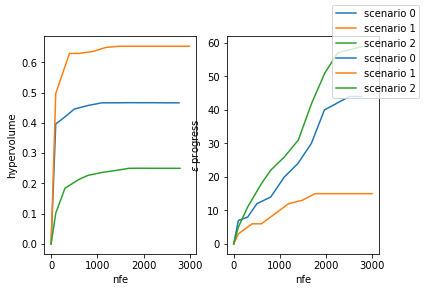

In [23]:
fig, (ax1, ax2) = plt.subplots(ncols=2,sharex=True)
for i, (_, convergence) in enumerate(results):
    ax1.plot(convergence.nfe, convergence.hypervolume, label=f'scenario {i}')
    ax2.plot(convergence.nfe, convergence.epsilon_progress, label=f'scenario {i}')

ax1.set_ylabel('hypervolume')
ax1.set_xlabel('nfe')
ax2.set_ylabel('$\epsilon$ progress')
ax2.set_xlabel('nfe')
fig.legend()
plt.show()

# PERFORMANCE OF POLICIES IN THEIR RESPECTIVE SCENARIO

In [31]:
for i, (result, _) in enumerate(results):
    result["scenario"] = cases[i]
    outcomes_df = pd.concat([outcomes_df, result], axis=0)

In [33]:
outcomes = [outcome.name for outcome in dike_model.outcomes]

In [34]:
outcomes = outcomes[2:]

In [35]:
policyoutcomes = outcomes_df.loc[:, outcomes]

In [36]:
policyoutcomes

,Gorssel Expected Annual Damage,Gorssel Expected Number of Deaths,Total Costs of Policies
0,9.233263e+06,0.004710,1.170471e+09
1,7.670043e+07,0.048534,8.411319e+08
2,1.770776e+07,0.008808,8.851280e+08
3,1.397205e+07,0.008365,1.210445e+09
4,5.989831e+07,0.030895,6.933502e+08
...,...,...,...
4,1.398112e+06,0.000972,1.354078e+09
5,1.535282e+08,0.075951,1.339817e+09
6,6.727411e+07,0.036334,1.347149e+09
7,4.721406e+06,0.003184,1.352403e+09


Below we plot per scenario 

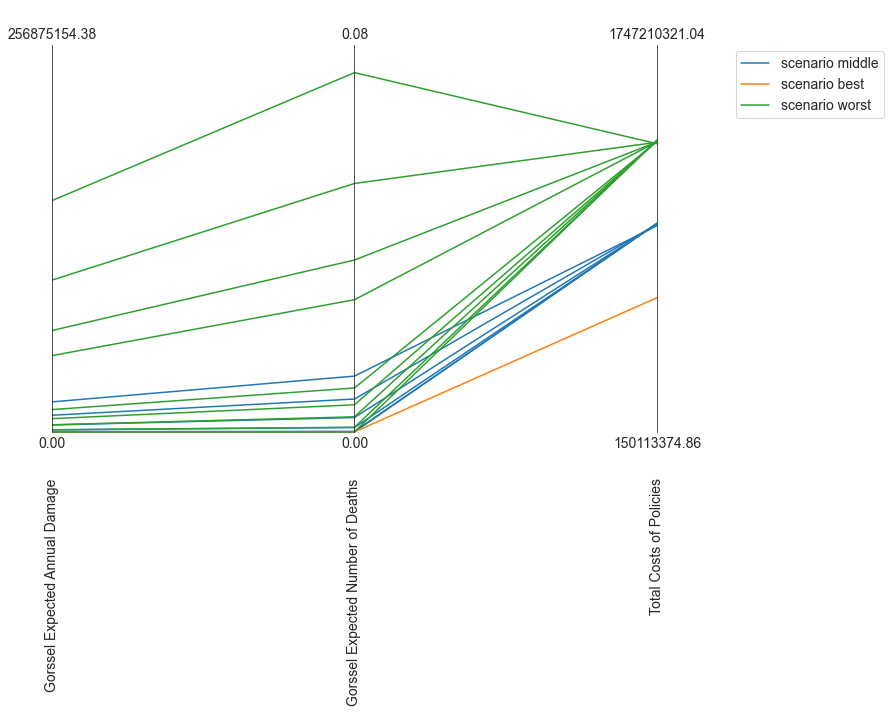

In [38]:
colors = iter(sns.color_palette())
limits = parcoords.get_limits(policyoutcomes)

# limits.loc[0, ['inertia', 'reliability']] = 1
# limits.loc[0, 'max_P'] = 4 # max over results based on quick inspection not shown here
# limits.loc[0, 'utility'] = 1 # max over results based on quick inspection not shown here
# limits.loc[1, :] = 0
paraxes = parcoords.ParallelAxes(limits)


for i, (result, _) in enumerate(results):
    color = next(colors)
    data = result.loc[:,  outcomes]
    paraxes.plot(data, label=f'scenario {cases[i]}', color=color)

paraxes.legend()
plt.rcParams["figure.figsize"] = (10,30)
plt.show()


# Re-evaluate under deep uncertainty

In [39]:
levers = [lever.name for lever in dike_model.levers]

In [40]:
policies = []
for i, (result, _) in enumerate(results):
    result = result.loc[:, levers]
    for j, row in result.iterrows():
        policy = Policy(f'scenario {cases[i]} option {j}', **row.to_dict())
        policies.append(policy)

In [ ]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    reeevaluation_results = evaluator.perform_experiments(1000, policies=policies)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 16 policies * 1 model(s) = 16000 experiments


## Regret

In [ ]:
policies = pd.DataFrame(results[0][0])
policies

In [ ]:
policies = pd.DataFrame(results[1][0])
policies

In [ ]:
thresholds = {}

### Kwakkels stuff - still have to test and adept but laptop sloooow

In [ ]:
experiments, outcomes = reeevaluation_results
overall_scores = {}
regret = []
for scenario in experiments.scenario.unique():
    logical = experiments.scenario==scenario
    temp_results = {k:v[logical] for k,v in outcomes.items()}
    temp_results = pd.DataFrame(temp_results)
    temp_experiments = experiments[experiments.scenario==scenario]
        
    best = temp_results.max()
    best['max_P'] = temp_results.max_P.min()
    scenario_regret = a - best
    scenario_regret['policy'] = temp_experiments.policy.values    
    regret.append(scenario_regret)

In [ ]:
regret = pd.concat(regret)
maxregret = regret.groupby('policy').max()

In [ ]:
limits = parcoords.get_limits(maxregret)
paraxes = parcoords.ParallelAxes(maxregret)
paraxes.plot(maxregret)
plt.show()

## Satisficing

In [ ]:
thresholds = {}